In [ ]:
import os

import librosa
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from keras import models
from sklearn.metrics import confusion_matrix

In [ ]:
data_dir = (
    "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/"
)
classes = [
    "blues",
    "classical",
    "country",
    "disco",
    "hiphop",
    "jazz",
    "metal",
    "pop",
    "reggae",
    "rock",
]

In [3]:
def load_and_preprocess_data(data_dir, classes, target_shape=(150, 150)):
    data = []
    labels = []
    for i_class, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        print("Processing--", class_name)
        for file_name in os.listdir(class_dir):
            if file_name.endswith(".wav"):
                file_path = os.path.join(class_dir, file_name)
                try:
                    # Try to load the audio file
                    audio_data, sample_rate = librosa.load(file_path, sr=None)

                    # Performing preprocessing
                    chunk_duration = 4
                    overlap_duration = 2
                    chunk_samples = chunk_duration * sample_rate
                    overlap_samples = overlap_duration * sample_rate
                    num_chunks = (
                        int(
                            np.ceil(
                                (len(audio_data) - chunk_samples)
                                / (chunk_samples - overlap_samples)
                            )
                        )
                        + 1
                    )

                    # Iterate over each chunk
                    for i in range(num_chunks):
                        start = i * (chunk_samples - overlap_samples)
                        end = start + chunk_samples
                        chunk = audio_data[start:end]
                        mel_spectrogram = librosa.feature.melspectrogram(
                            y=chunk, sr=sample_rate
                        )

                        # Resize matrix to the target shape
                        mel_spectrogram = tf.image.resize(
                            np.expand_dims(mel_spectrogram, axis=-1), target_shape
                        )
                        data.append(mel_spectrogram)
                        labels.append(i_class)
                except Exception as e:
                    # Handle the exception and skip the corrupted file
                    print(f"Error processing file {file_path}: {e}")

    return np.array(data), np.array(labels)

In [4]:
data, labels = load_and_preprocess_data(data_dir, classes)

Processing-- blues
Processing-- classical
Processing-- country
Processing-- disco
Processing-- hiphop
Processing-- jazz


<ipython-input-3-593886e764ee>:12: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sample_rate = librosa.load(file_path, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing file /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav: 
Processing-- metal
Processing-- pop
Processing-- reggae
Processing-- rock


In [5]:
from keras import utils

labels = utils.to_categorical(labels, num_classes=len(classes))

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42
)

In [7]:
from keras import layers

model = models.Sequential()

# convolutional layers parameters
conv_layers = [
    (32, 2),
    (64, 2),
    (128, 2),
    (256, 2),
    (512, 2),
]

# Input layer
model.add(
    layers.Conv2D(
        filters=conv_layers[0][0],
        kernel_size=3,
        padding="same",
        activation="relu",
        input_shape=X_train[0].shape,
    )
)

# Convolutional layers
for filters, num_layers in conv_layers:
    for _ in range(num_layers - 1):
        model.add(layers.Conv2D(filters=filters, kernel_size=3, activation="relu"))
    model.add(layers.MaxPool2D(pool_size=2, strides=2))
    if filters >= 128:
        model.add(layers.Dropout(0.3))

# Full connected layers
model.add(layers.Flatten())
model.add(layers.Dense(units=1200, activation="relu"))
model.add(layers.Dropout(0.45))
model.add(layers.Dense(units=len(classes), activation="softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
from keras import optimizers

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [9]:
from keras import callbacks

checkpoint = callbacks.ModelCheckpoint(
    "working/model_weights.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
)

In [10]:
training_history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint],
)

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.1650 - loss: 2.8569 - val_accuracy: 0.3609 - val_loss: 2.0349
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.2922 - loss: 1.9806 - val_accuracy: 0.4280 - val_loss: 1.6270
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4314 - loss: 1.6188 - val_accuracy: 0.4805 - val_loss: 1.4766
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.5085 - loss: 1.4187 - val_accuracy: 0.5713 - val_loss: 1.2508
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.5529 - loss: 1.3061 - val_accuracy: 0.5907 - val_loss: 1.1648
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.5737 - loss: 1.2080 - val_accuracy: 0.6224 - val_loss: 1.0632
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.6203 - loss: 1.1147 - val_accuracy: 0.6534 - val_loss: 1.0111
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.6446 - loss: 1

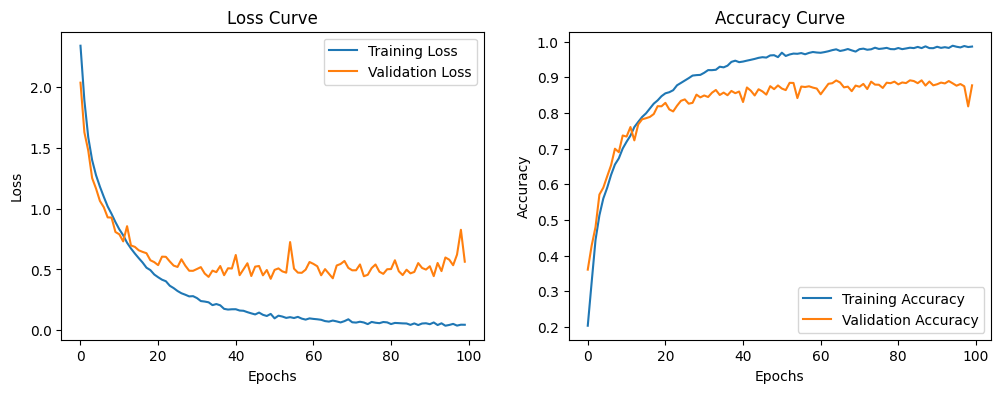

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_history.history["loss"], label="Training Loss")
plt.plot(training_history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_history.history["accuracy"], label="Training Accuracy")
plt.plot(training_history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.savefig("loss_accuracy.pdf", dpi=300)
plt.show()

In [17]:
# calculate accuracy
accuracy = np.sum(y_pred_classes == y_true_classes) / len(y_true_classes)
accuracy

0.8771285475792988

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


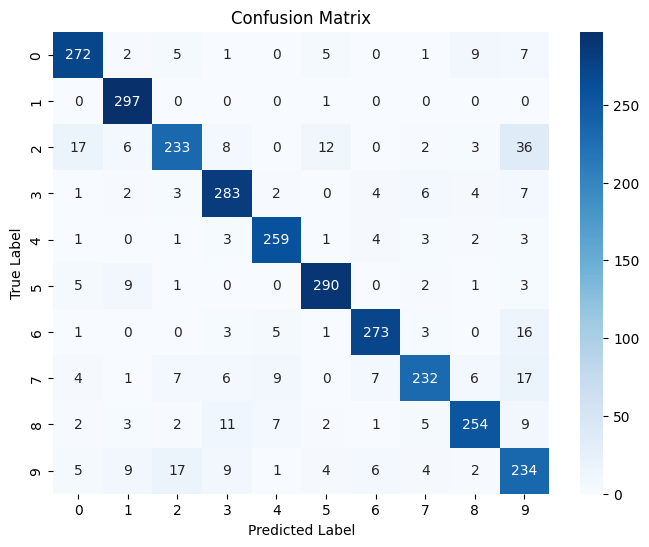

In [15]:
model = models.load_model("working/model_weights.keras")
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=range(len(cm)),
    yticklabels=range(len(cm)),
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
# save the plot
plt.savefig("cnn_evaluation.pdf", dpi=300)
plt.show()

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

precision = precision_score(y_true_classes, y_pred_classes, average="macro")
recall = recall_score(y_true_classes, y_pred_classes, average="macro")
f1 = f1_score(y_true_classes, y_pred_classes, average="macro")

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.8791778507415812
Recall: 0.8775841032137531
F1-score: 0.8768826437374232
